In [1]:
import pandas as pd
import numpy as np

import math
import time

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
data = pd.read_csv('../data/loan.csv', low_memory = False)

## Printing the shape of the dataset and the first 5 rows 

In [5]:
print('Shape of the dataset: ', data.shape)
data.head()

Shape of the dataset:  (887379, 74)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
data.describe(include=['O'])

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,verification_status_joint
count,887379,887379,887379,835917,842554,887379,887379,887379,887379,887379,...,887227,887379,887379,887350,887379,869720,634408,887326,887379,511
unique,2,7,35,299271,11,6,3,103,10,2,...,63144,935,51,697,2,98,100,103,2,3
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Source Verified,Oct-2015,Current,n,...,Debt consolidation,945xx,CA,Aug-2001,f,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL,Not Verified
freq,621125,254535,56323,13469,291569,443557,329558,48631,601779,887369,...,414001,9770,129517,6659,456848,470150,553406,730574,886868,283


## Counting all the null values from the columns of the dataset

In [6]:
data.isnull().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       51462
emp_length                      44825
home_ownership                      0
annual_inc                          4
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                           761351
purpose                             0
title                             152
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        29
earliest_cr_

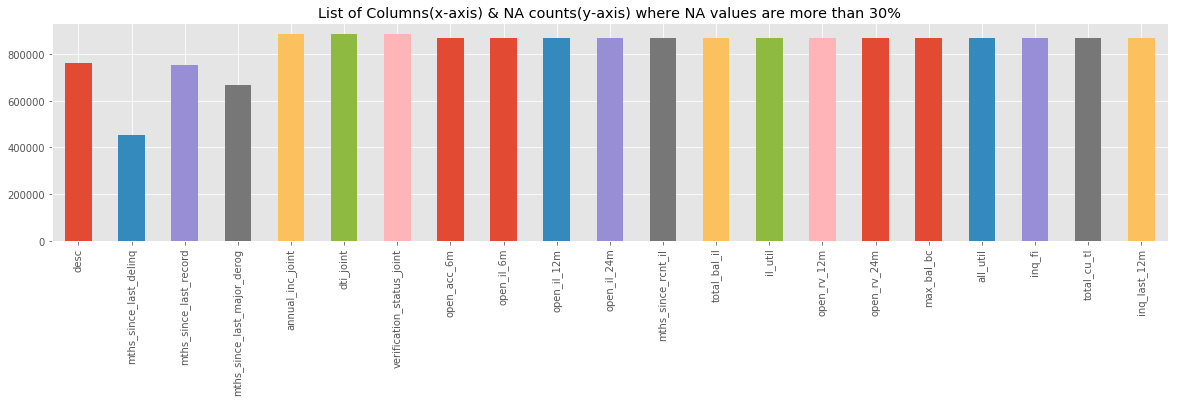

In [31]:
NA_col = data.isnull().sum()
NA_col = NA_col[NA_col.values >(0.3*len(data))]
plt.figure(figsize=(20,4))
NA_col.plot(kind='bar')
plt.title('List of Columns(x-axis) & NA counts(y-axis) where NA values are more than 30%')
plt.show()

In [48]:
(data.isnull().sum()/len(data))*100

id                              0.000000
member_id                       0.000000
loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
term                            0.000000
int_rate                        0.000000
installment                     0.000000
grade                           0.000000
sub_grade                       0.000000
emp_title                       5.799326
emp_length                      5.051393
home_ownership                  0.000000
annual_inc                      0.000451
verification_status             0.000000
issue_d                         0.000000
loan_status                     0.000000
pymnt_plan                      0.000000
url                             0.000000
desc                           85.797726
purpose                         0.000000
title                           0.017129
zip_code                        0.000000
addr_state                      0.000000
dti             

## Describing a few important columns such as int_rate, loan_amnt, emp_length:

In [17]:
print('Describing interest rate feature:\n',data['int_rate'].describe())
print('\nDescribing loan amount feature:\n',data['loan_amnt'].describe())
print('\nDescribing employement length feature:\n',data['emp_length'].describe())

Describing interest rate feature:
 count    887379.000000
mean         13.246740
std           4.381867
min           5.320000
25%           9.990000
50%          12.990000
75%          16.200000
max          28.990000
Name: int_rate, dtype: float64

Describing loan amount feature:
 count    887379.000000
mean      14755.264605
std        8435.455601
min         500.000000
25%        8000.000000
50%       13000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

Describing employement length feature:
 count        842554
unique           11
top       10+ years
freq         291569
Name: emp_length, dtype: object


## Finding the data-type of each column in dataset

In [29]:
for column in data:
    a = data[column].dtype
    print('Data-type for',column, 'is: ', a)

Data-type for id is:  int64
Data-type for member_id is:  int64
Data-type for loan_amnt is:  float64
Data-type for funded_amnt is:  float64
Data-type for funded_amnt_inv is:  float64
Data-type for term is:  object
Data-type for int_rate is:  float64
Data-type for installment is:  float64
Data-type for grade is:  object
Data-type for sub_grade is:  object
Data-type for emp_title is:  object
Data-type for emp_length is:  object
Data-type for home_ownership is:  object
Data-type for annual_inc is:  float64
Data-type for verification_status is:  object
Data-type for issue_d is:  object
Data-type for loan_status is:  object
Data-type for pymnt_plan is:  object
Data-type for url is:  object
Data-type for desc is:  object
Data-type for purpose is:  object
Data-type for title is:  object
Data-type for zip_code is:  object
Data-type for addr_state is:  object
Data-type for dti is:  float64
Data-type for delinq_2yrs is:  float64
Data-type for earliest_cr_line is:  object
Data-type for inq_last_6m

## Finding the number of people in respective states

Text(0.5, 1.0, 'Address(State)')

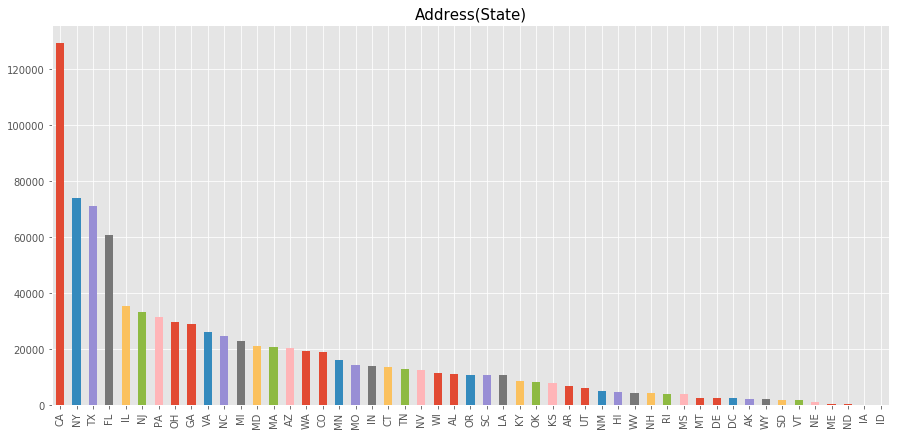

In [48]:
fig = plt.figure(figsize=(15,7))
data.addr_state.value_counts().plot(kind = 'bar', rot = 90)
plt.title('Address(State)',fontsize=15)

## Plotting the employement length and title of different borrowers

Text(0.5, 1.0, 'Employement length')

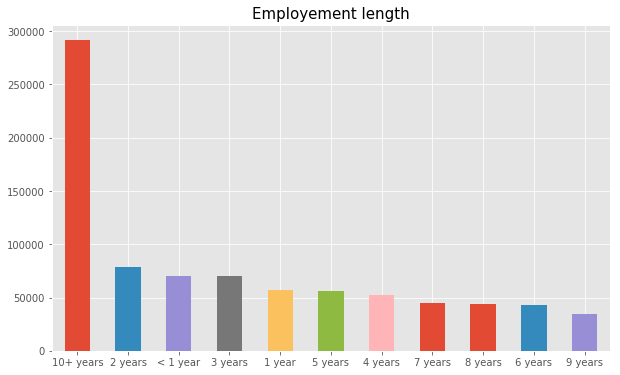

In [52]:
fig = plt.figure(figsize=(10,6))
data.emp_length.value_counts().plot(kind = 'bar', rot = 360)
plt.title('Employement length',fontsize=15)

Text(0.5, 1.0, 'Employement Title')

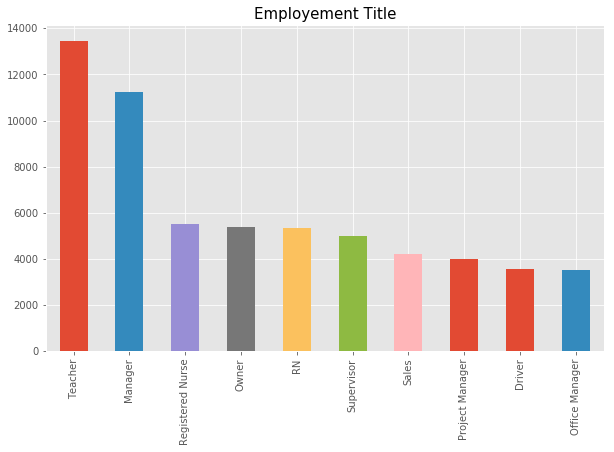

In [61]:
fig = plt.figure(figsize=(10,6))
data.emp_title.value_counts()[0:10].plot(kind = 'bar', rot = 90)
plt.title('Employement Title',fontsize=15)

## Home ownership values are either RENT, OWN, MORTGAGE or OTHER. Plotting bar graph to show the values for each ownership

Text(0.5, 1.0, 'Home Ownership')

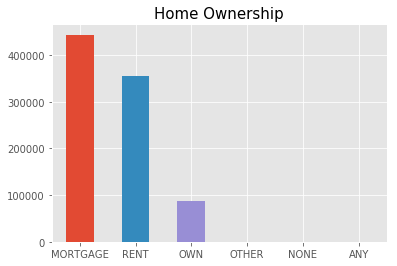

In [62]:
data.home_ownership.value_counts().plot(kind = 'bar', rot = 360)
plt.title('Home Ownership',fontsize=15)

Text(0.5, 1.0, 'Verification Status')

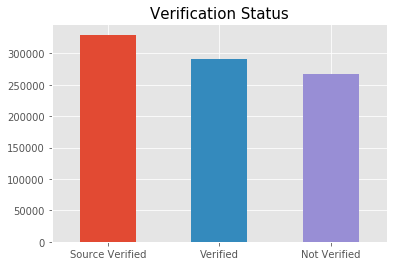

In [81]:
data.verification_status.value_counts().plot(kind = 'bar', rot = 360)
plt.title('Verification Status',fontsize=15)

Text(0.5, 1.0, 'Employement length')

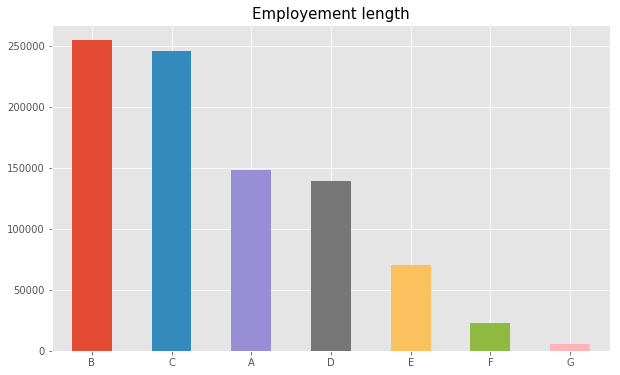

In [84]:
fig = plt.figure(figsize=(10,6))
data.emp_length.value_counts().plot(kind = 'bar', rot = 360)
plt.title('Employement length',fontsize=15)

Loan Amount Distribution BoxPlot


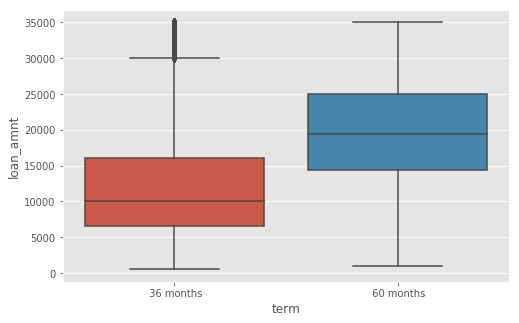

In [25]:
print("Loan Amount Distribution BoxPlot")
plt.figure(figsize=(8,5))
sns.boxplot(x=data.term, y=data.loan_amnt)

In [3]:
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 8,6

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

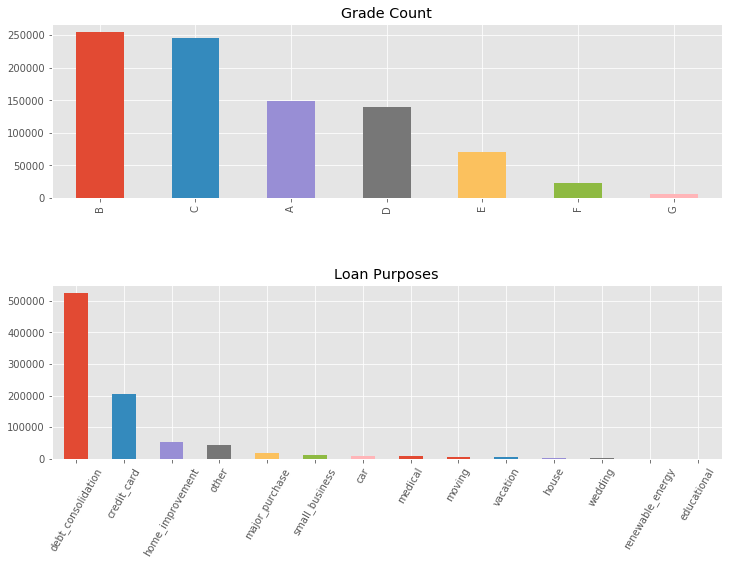

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plt.subplots_adjust(wspace=1.0, hspace=0.50)
data.grade.value_counts().plot(kind="bar", ax=ax[0])
ax[0].set_title("Grade Count")
data.purpose.value_counts().plot(kind="bar", ax=ax[1])
ax[1].set_title("Loan Purposes")
plt.xticks(rotation=60)

In [32]:
def univariate(data,col,vartype,hue =None):

    sns.set(style="darkgrid")
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(data[col],ax=ax[0])
        ax[1].set_title("Violin Plot")
        sns.violinplot(data =data, x=col,ax=ax[1], inner="quartile")
        ax[2].set_title("Box Plot")
        sns.boxplot(data =data, x=col,ax=ax[2],orient='v')
    
    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(data[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = data, x= col, order=data[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(loan))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
        
    plt.show()

C:\Users\Nidhi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


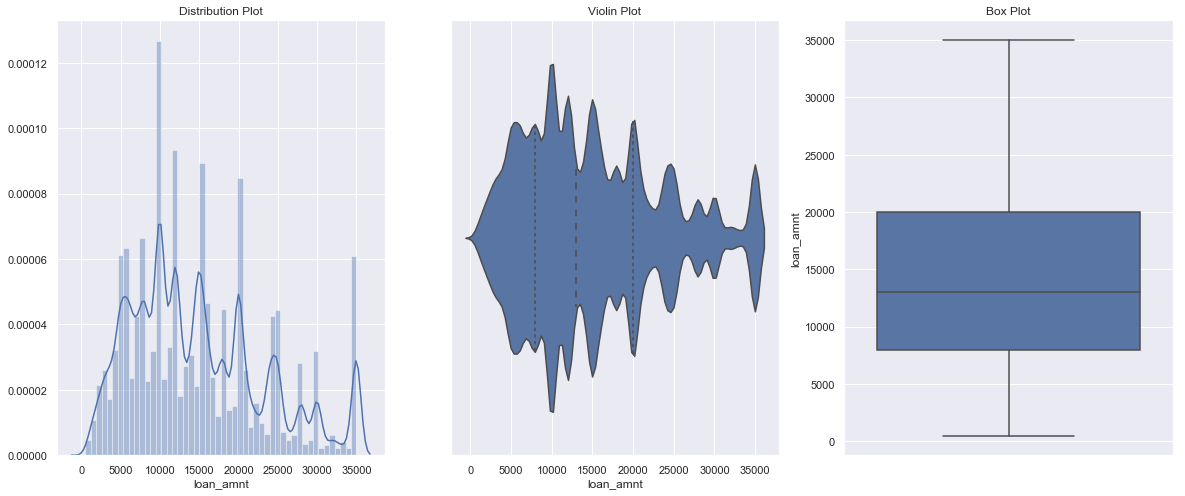

In [34]:
univariate(data=data,col='loan_amnt',vartype=0)

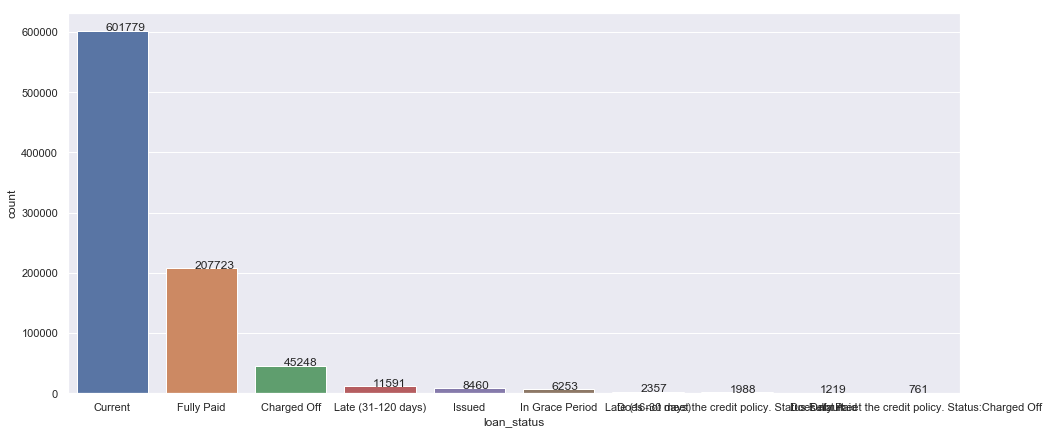

In [42]:
univariate(data=data,col='loan_status',vartype=1)

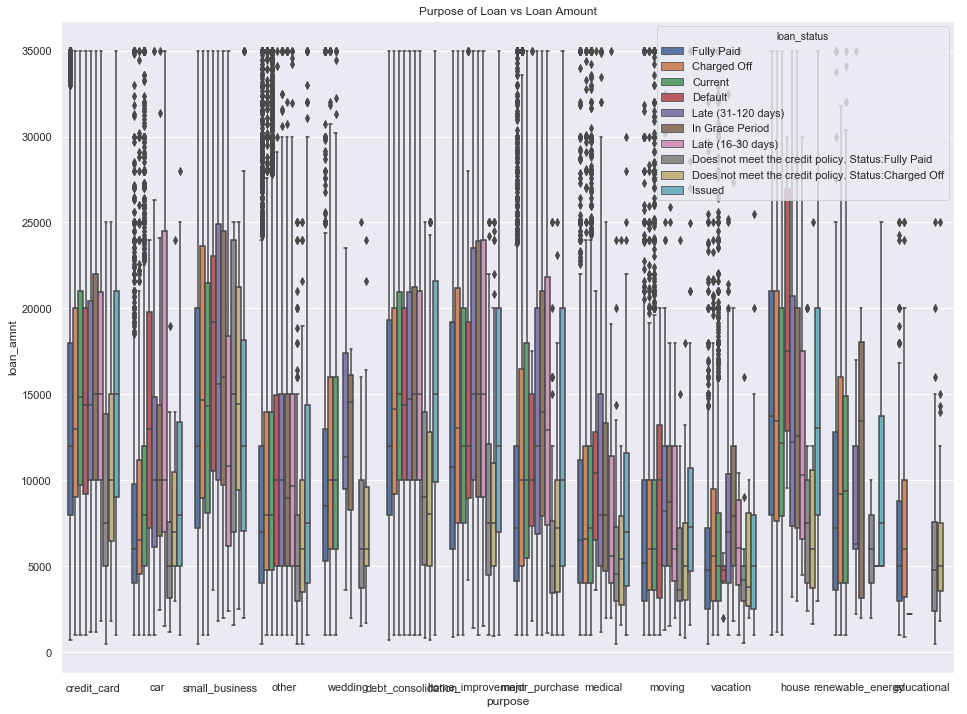

In [43]:
plt.figure(figsize=(16,12))
sns.boxplot(data =data, x='purpose', y='loan_amnt', hue ='loan_status')
plt.title('Purpose of Loan vs Loan Amount')
plt.show()

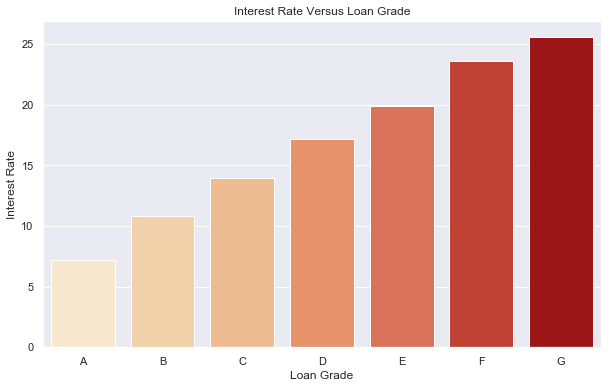

In [50]:
plt.figure(figsize=(10,6))
plot_data = data.groupby('grade')['int_rate'].mean()
ax = sns.barplot(x=plot_data.index,y=plot_data.values,palette='OrRd')
ax = plt.xlabel('Loan Grade')
ax = plt.ylabel('Interest Rate')
ax = plt.title('Interest Rate Versus Loan Grade')

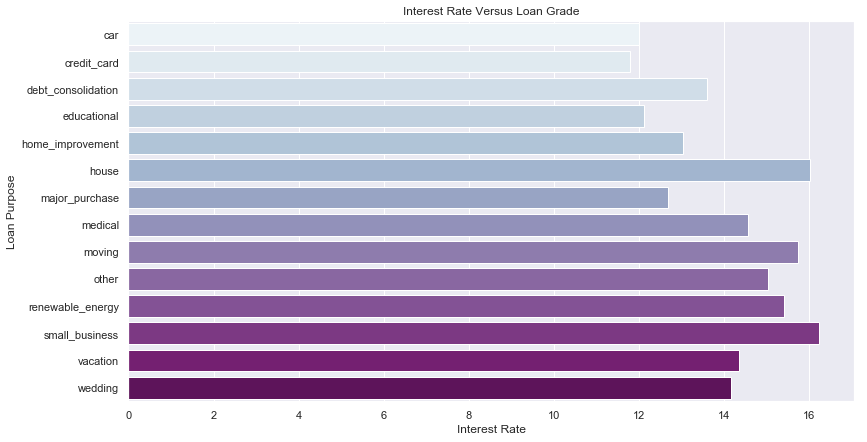

In [51]:
plt.figure(figsize=(13,7))
plot_data = data.groupby('purpose')['int_rate'].mean()
ax = sns.barplot(y=plot_data.index,x=plot_data.values,palette='BuPu')
ax = plt.ylabel('Loan Purpose')
ax = plt.xlabel('Interest Rate')
ax = plt.title('Interest Rate Versus Loan Grade')

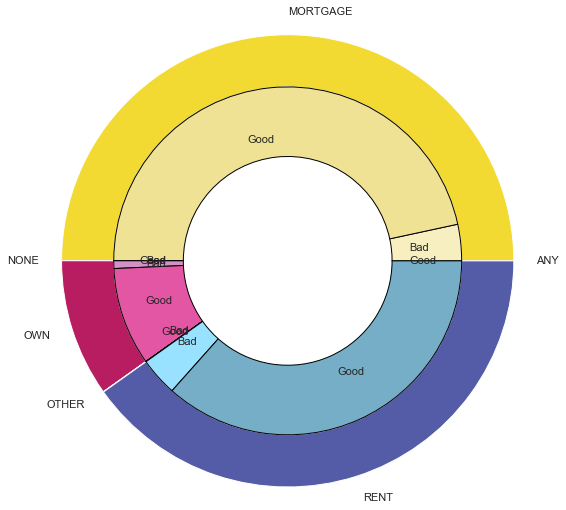

In [56]:
data = data[data['loan_status'] != 'Issued']
loan_type_dict = {
    'Fully Paid': 'Good',
    'Charged Off': 'Bad',
    'Current': 'Good',
    'Default': 'Bad',
    'Late (31-120 days)': 'Bad',
    'In Grace Period': 'Bad',
    'Late (16-30 days)': 'Bad',
    'Does not meet the credit policy. Status:Fully Paid': 'Good',
    'Does not meet the credit policy. Status:Charged Off': 'Bad'
}

data['loan_type'] = data['loan_status'].map(loan_type_dict)


target_dict = {
    'Good': 0,
    'Bad' : 1
}

data['target'] = data['loan_type'].map(target_dict)

plot_data1 = data.groupby(['home_ownership','loan_type']).size().unstack().fillna(0)
plot_data1['total'] = plot_data1['Bad'] + plot_data1['Good']
cols = ['ANY','MORTGAGE','NONE','OWN','OTHER','RENT']
plot_data1 = plot_data1.reindex(index=cols)

plot_data2 = data.groupby(['home_ownership','loan_type']).size().reset_index().fillna(0)
plot_data2.columns = ['home_ownership', 'loan_type','value']
plot_data2 = plot_data2.reindex([0,1,2,3,4,7,8,5,6,9,10])
plt.figure(figsize=(8,8))
ax = plt.axis('equal')

# Plot the outer circle
pie, _ = plt.pie(np.array(plot_data1['total']), radius=1.3,labels=plot_data1.index,colors=['#13194c','#f2da32','#2fb74d','#b71d60','#91683a','#545ca8'])
ax = plt.setp(pie, width=0.3, edgecolor='white')
 
# Plot the inner circle
pie2, _ = plt.pie(plot_data2.value.values, radius=1.3-0.3, labels=plot_data2['loan_type'].values, labeldistance=0.7,
                   colors = ['#91683a','#f7efc0','#efe294','#b7ba3f','#b7ba3f','#d192c5','#e256a3','#b7ba3f','#b7ba3f','#99e2ff','#75aec6'])
ax = plt.setp(pie2, width=0.4, edgecolor='black')
ax = plt.margins(0,0)